In [1]:
from __future__ import print_function
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Preprocessing
Can skip past this part, not really important...

In [2]:
ta_data = pickle.load(open("data/tripadvisor_reviews.pickle", 'rb'))
airbnb_data = pickle.load(open("data/airbnb_reviews.pickle", 'rb'))

In [3]:
ta_listings = pickle.load(open("data/tripadvisor_hotel_info.pickle", 'rb'))
airbnb_listings = pickle.load(open("data/airbnb_listings.pickle", 'rb'))

In [4]:
ta_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=0.9)
airbnb_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=0.9)
total_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=0.9)

In [5]:
ta_listing_to_index = {}
ta_index_to_listing = {}
for i,d in enumerate(ta_listings.items()):
    ta_listing_to_index[d[0]] = i
    ta_index_to_listing[i] = d[0]

ta_reviews = []
ta_adj_mat = np.zeros((len(ta_listing_to_index), len(ta_data)))
for j,d in enumerate(ta_data):
    i = ta_listing_to_index[d['hotel_name']]
    ta_reviews.append(d['review'])
    ta_adj_mat[i,j] += 1
    
ta_mat_index_to_listing = {}
for i,_ in enumerate(ta_listings.items()):
    ta_mat_index_to_listing[i] = i
    

airbnb_index_to_listing = {}
airbnb_listing_to_mat_index = {}
airbnb_mat_index_to_listing = {}
airbnb_reviews = []
i = 0
for (ind, (listing_id, reviews)) in enumerate(airbnb_data.items()):
    for review in reviews:
        airbnb_reviews.append(review)
        airbnb_listing_to_mat_index[listing_id] = ind
        airbnb_mat_index_to_listing[ind] = listing_id
        airbnb_index_to_listing[i] = listing_id
        i += 1
count = i
airbnb_adj_mat = np.zeros((len(airbnb_data),i))
for (j, l) in airbnb_index_to_listing.items():
    airbnb_adj_mat[airbnb_listing_to_mat_index[l],j] += 1 
    
total_adj_mat = np.zeros((len(ta_listing_to_index)+len(airbnb_data),len(ta_data)+count))
total_index_to_listing = {}
total_mat_index_to_listing = {}
for j,d in enumerate(ta_data):
    i = ta_listing_to_index[d['hotel_name']]
    ta_adj_mat[i,j] += 1
    total_mat_index_to_listing[i] = i
for (j, l) in airbnb_index_to_listing.items():
    row = len(ta_listing_to_index)+airbnb_listing_to_mat_index[l]
    col = len(ta_data)+j
    total_adj_mat[row,col] += 1 
    total_mat_index_to_listing[row] = l

total_reviews = ta_reviews + airbnb_reviews

In [6]:
ta_tfidf = ta_vectorizer.fit_transform(ta_reviews)
airbnb_tfidf = airbnb_vectorizer.fit_transform(airbnb_reviews)
total_tfidf = total_vectorizer.fit_transform(total_reviews)

In [7]:
ta_lda_ht = pickle.load(open("data/ta_lda_ht.mat"))
ta_lda_dt = pickle.load(open("data/ta_lda_dt.mat"))
ta_lda_tt = pickle.load(open("data/ta_lda_tt.mat"))
airbnb_lda_ht = pickle.load(open("data/airbnb_lda_ht.mat"))
airbnb_lda_dt = pickle.load(open("data/airbnb_lda_dt.mat"))
airbnb_lda_tt = pickle.load(open("data/airbnb_lda_tt.mat"))
total_lda_ht = pickle.load(open("data/total_lda_ht.mat"))
total_lda_dt = pickle.load(open("data/total_lda_dt.mat"))
total_lda_tt = pickle.load(open("data/total_lda_tt.mat"))

print(ta_lda_ht.shape)
print(ta_lda_dt.shape)
print(ta_lda_tt.shape)
print()
print(airbnb_lda_ht.shape)
print(airbnb_lda_dt.shape)
print(airbnb_lda_tt.shape)
print()
print(total_lda_ht.shape)
print(total_lda_dt.shape)
print(total_lda_tt.shape)

(78, 10)
(46606, 10)
(10, 227)

(7993, 10)
(90003, 10)
(10, 157)

(8071, 10)
(136609, 10)
(10, 181)


# SVD Analysis
We want to see how as the number of dimensions, how much more of the data is encapsulated, which can be seen using the singular values, as shown in the plot.

In [8]:
u, s, v_trans = svds(total_tfidf, k=100)
v = v_trans.T

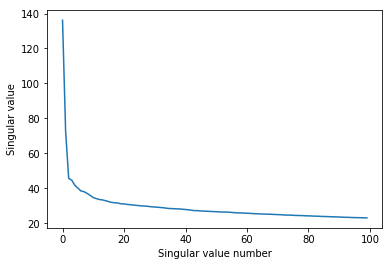

In [9]:
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

# Number of Topics
Seems reasonable to use anything above 40, and we can increase that number, but make sure to see how that affects the results below for the searches. This is a hyper-parameter we can tune by eye.

In [10]:
total_svd_dt, total_svd_s, total_svd_tt = svds(total_tfidf, k=100)

In [50]:
ta_svd_dt, ta_svd_s, ta_svd_tt = svds(ta_tfidf, k = 100)
airbnb_svd_dt, airbnb_svd_s, airbnb_svd_tt = svds(airbnb_tfidf, k = 100)

In [54]:
pickle.dump(ta_svd_s, open("data/ta_svd_s.pickle", "wb"))
pickle.dump(ta_svd_tt, open("data/ta_svd_tt.pickle", "wb"))
pickle.dump(airbnb_svd_s, open("data/airbnb_svd_s.pickle", "wb"))
pickle.dump(airbnb_svd_tt, open("data/airbnb_svd_tt.pickle", "wb"))

In [11]:
pickle.dump(total_svd_s, open("data/total_svd_s.pickle", "wb"))
pickle.dump(total_svd_tt, open("data/total_svd_tt.pickle", "wb"))

### Hotel Relation Matrix
Use this matrix if you want to find hotels (Airbnb or TA) that are related to whatever listing you want. Computation takes a while though, beware.

In [12]:
total_svd_ht = np.matmul(total_adj_mat, total_svd_dt)

## Evaluating how SVD does based only on our corpus
Take a look at a couple of queries and the "similar" words based on our corpus. If you don't like the results, adjust the number of topics (k in the svds command above).

In [62]:
ta_word_to_index = ta_vectorizer.vocabulary_
ta_index_to_word = {i:t for t,i in ta_word_to_index.iteritems()}
airbnb_word_to_index = airbnb_vectorizer.vocabulary_
airbnb_index_to_word = {i:t for t,i in airbnb_word_to_index.iteritems()}
total_word_to_index = total_vectorizer.vocabulary_
total_index_to_word = {i:t for t,i in total_word_to_index.iteritems()}

In [63]:
def closest_words(word_in, total_svd_s, total_svd_tt, word_to_index, index_to_word, k = 5):
    if word_in not in word_to_index: return []
    sims = np.matmul(total_svd_tt.T, np.multiply(total_svd_s, total_svd_tt[:, word_to_index[word_in]]))
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]/sims[asort[0]]) for i in asort[1:]]

def pretty_print(q, array_of_tuples):
    print("Word: " + q)
    print("*" * (len(q)+5))
    for (w, sc) in array_of_tuples:
        print(w + ": " + str(sc))
    print("*" * (len(q)+5))
    print()
# pretty_print("quiet", closest_words("quiet", total_svd_s, total_svd_tt))
# pretty_print("clean", closest_words("clean", total_svd_s, total_svd_tt))
# pretty_print("breakfast", closest_words("breakfast", total_svd_s, total_svd_tt))
# pretty_print("close", closest_words("close", total_svd_s, total_svd_tt))

In [64]:
pretty_print("clean", closest_words("clean", ta_svd_s, ta_svd_tt, ta_word_to_index, ta_index_to_word))
pretty_print("clean", closest_words("clean", airbnb_svd_s, airbnb_svd_tt, airbnb_word_to_index, airbnb_index_to_word))

Word: clean
**********
room: 0.19488199543
hotel: 0.187251341623
modern: 0.180513907709
comfortable: 0.156975443669
rooms: 0.146480896435
**********

Word: clean
**********
bathroom: 0.238421694506
apartment: 0.208954686354
place: 0.190208253283
towels: 0.178079409905
comfortable: 0.15465051739
**********



# LDA Search
I've just augmented the query using whatever words ```closest_words``` returns. This is obviously super naive, and gives very high similarity scores because of that, so we can definitely trim this down, but this is just a starting point to work off of.

In [15]:
def print_top_words(mat, feature_names, n_top_words):
    for topic_idx, topic in enumerate(mat):
        print("Rank #%d:" % topic_idx)
        indices = topic.argsort()[:-n_top_words - 1:-1]
        print(" ".join([feature_names[i] for i in indices if topic[i] > 0]))
    print()

In [16]:
ta_tfidf_feature_names = ta_vectorizer.get_feature_names()
airbnb_tfidf_feature_names = airbnb_vectorizer.get_feature_names()
total_tfidf_feature_names = total_vectorizer.get_feature_names()

In [65]:
def search_lda(query, vectorizer, ht_mat, tt_mat, mat_to_listing_dict, 
               svd_weights, svd_topics, word_to_index, index_to_word, top_k = 10):
    related_words = []
    for q in query.split():
        related_words += closest_words(q, svd_weights, svd_topics, word_to_index, index_to_word)
    related_words = list(set(related_words))
    related_words = [w[0] for w in sorted(related_words, key = lambda item: item[1], reverse = True)[:5]]
    print(related_words)
    vec = vectorizer.transform([query]).todense().T
    results = np.dot(ht_mat, normalize(np.dot(tt_mat, vec), axis = 0)).T
    indices = np.squeeze(np.asarray(np.argsort(results)))[::-1].T[:top_k]
    scores = np.squeeze(np.asarray(np.sort(results)))[::-1].T[:top_k]    
    listings = np.zeros(indices.shape)
    for i in range(indices.shape[0]):
        listings[i] = mat_to_listing_dict[indices[i]]
    return (listings.tolist(), indices.tolist(), scores.tolist(), related_words)

In [66]:
listings, indices, scores, related_words = search_lda("close", 
                                       airbnb_vectorizer, 
                                       airbnb_lda_ht, 
                                       airbnb_lda_tt, 
                                       airbnb_mat_index_to_listing, 
                                       airbnb_svd_s, 
                                       airbnb_svd_tt,
                                       airbnb_word_to_index,
                                       airbnb_index_to_word)

[u'subway', u'apartment', u'restaurants', u'great', u'place']


In [67]:
for (l, ind, score) in zip(listings, indices, scores):
    listing_id = str(int(l))
    airbnb_listing_info = airbnb_listings[listing_id]
    print("Listing ID: " + listing_id)
    print("Listing Name: " + airbnb_listing_info['name'])
#     print("Review : \n" + airbnb_reviews[ind])
    print("Listing URL: " + airbnb_listing_info['listing_url'])
    print("Image URL: " + airbnb_listing_info['picture_url'])
    print("Score (Similarity): " + str(score))
    print("**************")

Listing ID: 8388457
Listing Name: Charming, Convenient, Private Bath
Listing URL: https://www.airbnb.com/rooms/8388457
Image URL: https://a0.muscache.com/im/pictures/36a0f0c2-b530-40b9-9a16-6f0e8c6c21bc.jpg?aki_policy=large
Score (Similarity): 0.985950942497
**************
Listing ID: 306799
Listing Name: 2 rooms; private entrance & bath!
Listing URL: https://www.airbnb.com/rooms/306799
Image URL: https://a0.muscache.com/im/pictures/3914841/2ea6fc25_original.jpg?aki_policy=large
Score (Similarity): 0.973793450501
**************
Listing ID: 1026592
Listing Name: Large East Village Bedroom To Let!
Listing URL: https://www.airbnb.com/rooms/1026592
Image URL: https://a0.muscache.com/im/pictures/21726900/19c843e1_original.jpg?aki_policy=large
Score (Similarity): 0.973057942317
**************
Listing ID: 1497024
Listing Name: Harlem Hamilton Hghts Apt.2 Bedrms
Listing URL: https://www.airbnb.com/rooms/1497024
Image URL: https://a0.muscache.com/im/pictures/77965282/d37ee662_original.jpg?aki_p

In [68]:
listings, indices, scores, related_words = search_lda("clean", 
                                       ta_vectorizer, 
                                       ta_lda_ht, 
                                       ta_lda_tt, 
                                       ta_mat_index_to_listing,
                                       ta_svd_s, 
                                       ta_svd_tt,
                                       ta_word_to_index,
                                       ta_index_to_word)

[u'room', u'hotel', u'modern', u'comfortable', u'rooms']


In [69]:
for (l, ind, score) in zip(listings, indices, scores):
    listing_id = str(int(l))
    
    ta_listing_info = ta_listings[ta_index_to_listing[int(l)]]
#     print("Listing ID: " + listing_id)
    print("Listing Name: " + ta_index_to_listing[int(l)])
#     print("Review : \n" + airbnb_reviews[ind])
    print("Listing URL: " + ta_listing_info[0])
#     print("Image URL: " + airbnb_listing_info['picture_url'])
    print("Score (Similarity): " + str(score))
    print("**************")

Listing Name: The Jewel facing Rockefeller Center 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d1913413-Reviews-The_Jewel_facing_Rockefeller_Center-New_York_City_New_York.html
Score (Similarity): 0.990466990901
**************
Listing Name: Holiday Inn Express New York City 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d584986-Reviews-Holiday_Inn_Express_New_York_City-New_York_City_New_York.html
Score (Similarity): 0.987450629376
**************
Listing Name: Ramada New York/Eastside 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d99388-Reviews-Ramada_New_York_Eastside-New_York_City_New_York.html
Score (Similarity): 0.986297478465
**************
Listing Name: Four Points by Sheraton Manhattan Chelsea 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d281234-Reviews-Four_Points_by_Sheraton_Manhattan_Chelsea-New_York_City_New_York.html
Score (Similarity): 0.978774600059
**************
Listing Name: The Tuscany - A St Giles Signatu

In [45]:
listings, indices, scores, related_words = search_lda("breakfast", 
                                       total_vectorizer, 
                                       total_lda_ht, 
                                       total_lda_tt, 
                                       total_mat_index_to_listing,
                                       total_svd_s, 
                                       total_svd_tt)

In [46]:
threshold = (ta_lda_ht.shape)[0]
for (l, ind, score) in zip(listings, indices, scores):
    if (ind > threshold):
        # Airbnb
        listing_id = str(int(l))
        airbnb_listing_info = airbnb_listings[listing_id]
        print("Listing ID: Airbnb " + listing_id)
        print("Listing Name (Airbnb): " + airbnb_listing_info['name'])
    #     print("Review : \n" + airbnb_reviews[ind])
        print("Listing URL: " + airbnb_listing_info['listing_url'])
        print("Image URL: " + airbnb_listing_info['picture_url'])
        print("Score (Similarity): " + str(score))
        print("**************")
    else:
        # Tripadvisor
        listing_id = str(int(l))

        ta_listing_info = ta_listings[ta_index_to_listing[int(l)]]
        print("Listing ID: Tripadvisor " + listing_id)
        print("Listing Name: " + ta_index_to_listing[int(l)])
    #     print("Review : \n" + airbnb_reviews[ind])
        print("Listing URL: " + ta_listing_info[0])
    #     print("Image URL: " + airbnb_listing_info['picture_url'])
        print("Score (Similarity): " + str(score))
        print("**************")

Listing ID: Tripadvisor 18
Listing Name: Redford Hotel 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d1583937-Reviews-Redford_Hotel-New_York_City_New_York.html
Score (Similarity): 0.967108469833
**************
Listing ID: Airbnb 6329973
Listing Name (Airbnb): Times Square room with private bath
Listing URL: https://www.airbnb.com/rooms/6329973
Image URL: https://a0.muscache.com/im/pictures/7befc35b-0d27-4669-b72b-2ccbfbe6ecbc.jpg?aki_policy=large
Score (Similarity): 0.963773043496
**************
Listing ID: Airbnb 1932459
Listing Name (Airbnb): Fantastic Central Park View Sleeps5
Listing URL: https://www.airbnb.com/rooms/1932459
Image URL: https://a0.muscache.com/im/pictures/26798865/1f0d8bc9_original.jpg?aki_policy=large
Score (Similarity): 0.960997294021
**************
Listing ID: Airbnb 8033609
Listing Name (Airbnb): Studio Apartment with King Bed
Listing URL: https://www.airbnb.com/rooms/8033609
Image URL: https://a0.muscache.com/im/pictures/c4fd2915-d3b5-4c36-be24-

In [71]:
pickle.dump(total_mat_index_to_listing, open("data/total_mat_index_to_listing.pickle", "wb"))